# Global Cyberattack Pattern Analysis — Data Mining (Anaconda Edition)

**Notebook:** 05_unsupervised_clustering.ipynb — KMeans + PCA visualization

Dataset shape: (1427, 6)


,vendorProject,product,cwe_primary,year_added,month_added,ransomware_known
0,Adobe,Flash Player and AIR,CWE-416,2022,5,False
1,Cisco,Adaptive Security Appliance (ASA) and Firepowe...,CWE-835,2024,4,False
2,PHP,PHPMailer,CWE-77,2025,7,False
3,Synacor,Zimbra Collaboration Suite (ZCS),CWE-79,2023,4,False
4,Zyxel,Multiple Network-Attached Storage (NAS) Devices,CWE-78,2023,6,False


Best K by silhouette: 3  (score=0.183)
Silhouette Score (final K): 0.183
✅ Saved plots & results to: C:\Users\asus\Downloads\global_cyberattack_dm_anaconda\global_cyberattack_dm\reports\unsupervised


{0: {'count': 403,
  'top_vendor': {'Microsoft': 71,
   'Ivanti': 21,
   'Apple': 14,
   'Google': 14,
   'Cisco': 13},
  'top_cwe': {'CWE-78': 31,
   'CWE-502': 26,
   'CWE-22': 23,
   'CWE-416': 20,
   'CWE-287': 16},
  'years': {2023: 14, 2024: 186, 2025: 203}},
 1: {'count': 584,
  'top_vendor': {'Microsoft': 169,
   'Adobe': 57,
   'Cisco': 51,
   'Apple': 32,
   'Oracle': 23},
  'top_cwe': {'CWE-119': 64,
   'CWE-20': 58,
   'CWE-78': 34,
   'CWE-416': 33,
   'CWE-94': 27},
  'years': {2022: 477, 2023: 107}},
 2: {'count': 440,
  'top_vendor': {'Microsoft': 98,
   'Apple': 38,
   'Google': 31,
   'Cisco': 17,
   'Apache': 16},
  'top_cwe': {'CWE-20': 47,
   'CWE-787': 42,
   'CWE-416': 29,
   'CWE-22': 28,
   'CWE-78': 23},
  'years': {2021: 296, 2022: 78, 2023: 66}}}

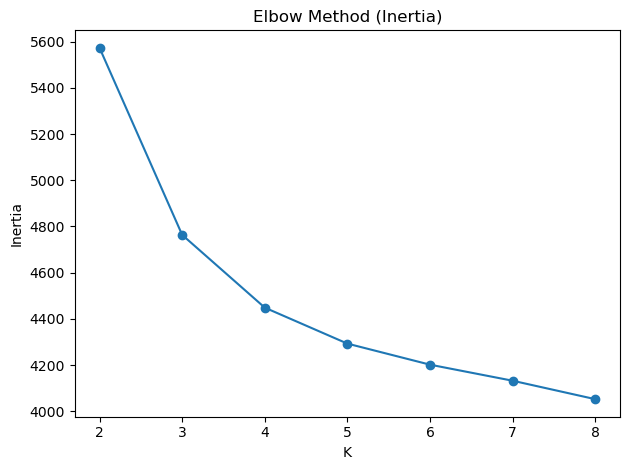

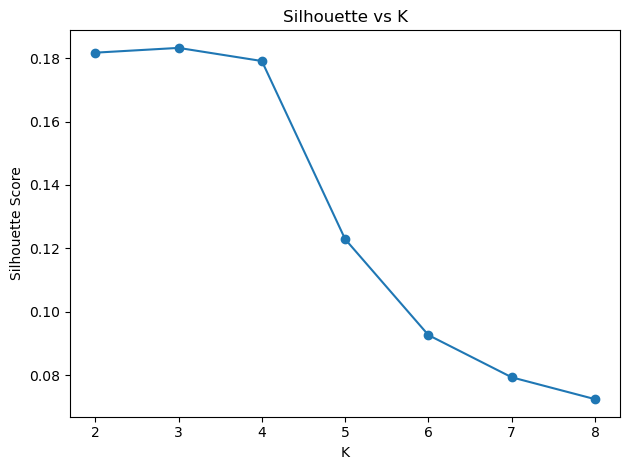

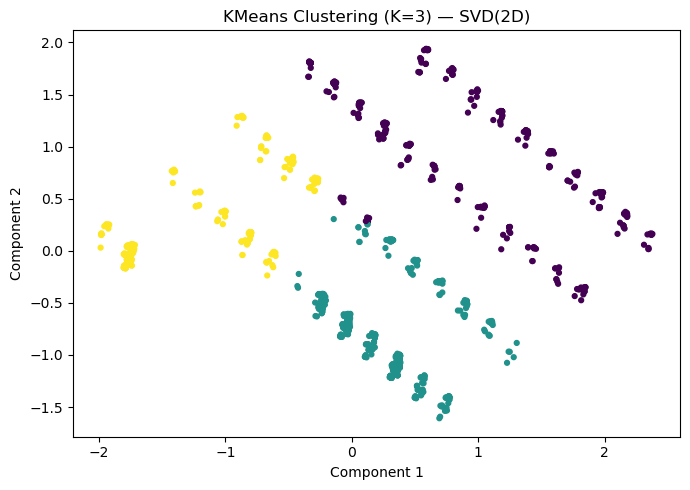

In [4]:

import pandas as pd, numpy as np, os, json
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import TruncatedSVD  # PCA for (possibly) sparse OHE matrix
import joblib


ROOT = Path.cwd()
if ROOT.name == "notebooks":
    ROOT = ROOT.parent
OUT_DIR = ROOT / "reports" / "unsupervised"
METRICS = ROOT / "reports" / "metrics"
OUT_DIR.mkdir(parents=True, exist_ok=True)

splits = joblib.load(METRICS / "splits.joblib")
df = pd.concat([splits["X_train"], splits["X_test"]], axis=0).reset_index(drop=True)
print("Dataset shape:", df.shape)
display(df.head())

# Categorical + numeric features that describe a vulnerability without labels

cat_cols = [c for c in ["vendorProject","product","cwe_primary"] if c in df.columns]
num_cols = [c for c in ["year_added","month_added"] if c in df.columns]
bool_cols = [c for c in ["ransomware_known"] if c in df.columns]
# Cast booleans to numeric for the numeric branch
for c in bool_cols:
    df[c] = df[c].astype(float)
num_cols += bool_cols

X = df[cat_cols + num_cols].copy()

# Preprocess (impute + encode + scale)
preprocess = ColumnTransformer([
    ("cat", Pipeline([
        ("imp", SimpleImputer(strategy="most_frequent")),
        ("oh",  OneHotEncoder(handle_unknown="ignore"))
    ]), cat_cols),
    ("num", Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("sc",  StandardScaler())
    ]), num_cols)
])

# Fit-transform to numeric matrix 

X_mat = preprocess.fit_transform(X)

#  Elbow & Silhouette 

K_range = range(2, 9)  # 2..8
inertias, sils = [], []
for k in K_range:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = km.fit_predict(X_mat)
    inertias.append(km.inertia_)
    sils.append(silhouette_score(X_mat, labels))

# Plot elbow

plt.figure()
plt.plot(list(K_range), inertias, marker="o")
plt.title("Elbow Method (Inertia)")
plt.xlabel("K"); plt.ylabel("Inertia"); plt.tight_layout()
plt.savefig(OUT_DIR / "elbow_inertia.png", dpi=200)

# Plot silhouette

plt.figure()
plt.plot(list(K_range), sils, marker="o")
plt.title("Silhouette vs K")
plt.xlabel("K"); plt.ylabel("Silhouette Score"); plt.tight_layout()
plt.savefig(OUT_DIR / "silhouette_scores.png", dpi=200)

# Choose best K by max silhouette

best_k = int(K_range[np.argmax(sils)])
print(f"Best K by silhouette: {best_k}  (score={max(sils):.3f})")

#  Final KMeans

kmeans = KMeans(n_clusters=best_k, n_init=10, random_state=42)
clusters = kmeans.fit_predict(X_mat)
df_clusters = df.copy()
df_clusters["cluster"] = clusters

# 2D visualization via TruncatedSVD (PCA for sparse)

svd = TruncatedSVD(n_components=2, random_state=42)
xy = svd.fit_transform(X_mat)
df_clusters["pc1"], df_clusters["pc2"] = xy[:,0], xy[:,1]

plt.figure(figsize=(7,5))
scatter = plt.scatter(df_clusters["pc1"], df_clusters["pc2"], c=df_clusters["cluster"], s=12)
plt.title(f"KMeans Clustering (K={best_k}) — SVD(2D)")
plt.xlabel("Component 1"); plt.ylabel("Component 2"); plt.tight_layout()
plt.savefig(OUT_DIR / f"clusters_k{best_k}_svd2d.png", dpi=220)

# Quality metric

sil = silhouette_score(X_mat, clusters)
print("Silhouette Score (final K):", round(sil, 3))

# Cluster summaries

summaries = {}
for k in range(best_k):
    sub = df_clusters[df_clusters["cluster"]==k]
    top_vendor = sub["vendorProject"].value_counts().head(5).to_dict() if "vendorProject" in sub else {}
    top_cwe    = sub["cwe_primary"].value_counts().head(5).to_dict() if "cwe_primary" in sub else {}
    year_cnt   = sub["year_added"].value_counts().sort_index().to_dict() if "year_added" in sub else {}
    summaries[k] = {"count": int(len(sub)), "top_vendor": top_vendor, "top_cwe": top_cwe, "years": year_cnt}

# Save artifacts

df_clusters.to_csv(OUT_DIR / f"clustered_assignments_k{best_k}.csv", index=False)
with open(OUT_DIR / f"clustering_summary_k{best_k}.json", "w", encoding="utf-8") as f:
    json.dump({"best_k": best_k, "silhouette": float(sil), "summaries": summaries}, f, ensure_ascii=False, indent=2)

print("✅ Saved plots & results to:", OUT_DIR)
summaries
